# Librerías

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import tensorflow as tf
import seaborn as sns
import torch
import json
from PIL import Image
from torch import nn, optim
from torchvision import datasets, transforms
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
import zipfile

In [ ]:
inputs_path = images_training_rev1.zip


# Análisis Exploratorio

In [ ]:
# Carga de los datos, se muestra la cantidad de muestras y clases dentro del dataset
df_train_sol = pd.read_csv('training_solutions_rev1.csv')
print('Shape: ', df_train_sol.shape)

Shape:  (61578, 38)


El dataset contiene los identificadores de cada imagen de galaxia y la probabilidad de cada clase.

In [ ]:
df_train_sol.head()

,GalaxyID,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,...,Class9.3,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6
0,100008,0.383147,0.616853,0.000000,0.000000,0.616853,0.038452,0.578401,0.418398,0.198455,...,0.000000,0.279952,0.138445,0.000000,0.000000,0.092886,0.0,0.0,0.0,0.325512
1,100023,0.327001,0.663777,0.009222,0.031178,0.632599,0.467370,0.165229,0.591328,0.041271,...,0.018764,0.000000,0.131378,0.459950,0.000000,0.591328,0.0,0.0,0.0,0.000000
2,100053,0.765717,0.177352,0.056931,0.000000,0.177352,0.000000,0.177352,0.000000,0.177352,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
3,100078,0.693377,0.238564,0.068059,0.000000,0.238564,0.109493,0.129071,0.189098,0.049466,...,0.000000,0.094549,0.000000,0.094549,0.189098,0.000000,0.0,0.0,0.0,0.000000
4,100090,0.933839,0.000000,0.066161,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000


## Is the object a smooth galaxy, a galaxy with features/disk or a star?
En este caso, solo nos concentramos en las clases asociadas a este nodo (3 clases)

In [ ]:
df_train_sol = df_train_sol[['GalaxyID','Class1.1','Class1.2','Class1.3']]
df_train_sol.head(10)

,GalaxyID,Class1.1,Class1.2,Class1.3
0,100008,0.383147,0.616853,0.000000
1,100023,0.327001,0.663777,0.009222
2,100053,0.765717,0.177352,0.056931
3,100078,0.693377,0.238564,0.068059
4,100090,0.933839,0.000000,0.066161
5,100122,0.738832,0.238159,0.023009
6,100123,0.462492,0.456033,0.081475
7,100128,0.687783,0.288344,0.023873
8,100134,0.021834,0.976952,0.001214
9,100143,0.269843,0.730157,0.000000


Text(50.722222222222214, 0.5, 'GalaxyID')

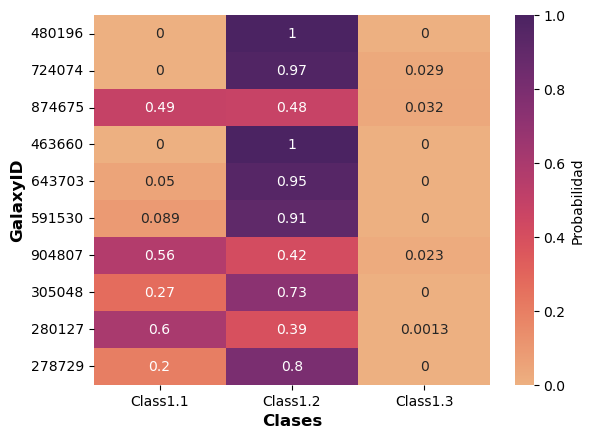

In [ ]:
ax = sns.heatmap(df_train_sol.sample(frac=1).head(10).set_index('GalaxyID'), annot=True, cmap='flare', cbar_kws={'label': 'Probabilidad'})
plt.xlabel('Clases',fontsize=12, fontweight='bold')
plt.ylabel('GalaxyID',fontsize=12, fontweight='bold')

In [ ]:
# Comprobando que sume 1 cada muestra
df_train_sol[['Class1.1', 'Class1.2', 'Class1.3']].sum(axis=1).unique()

array([1.      , 1.      , 0.999999, 1.000001, 0.999999, 1.000001,
       0.999999, 1.      ])

In [ ]:
# Verificando presencia de nulos o muestras duplicadas
nulos_totales = df_train_sol.isnull().sum().sum()
duplicados_totales = df_train_sol.duplicated().sum()
print('Valores nulos totales: {}'.format(nulos_totales))
print('Valores duplicados: {}'.format(duplicados_totales))

Valores nulos totales: 0
Valores duplicados: 0


In [ ]:
# Como exploración básica, se muestran los estadisticos principales
df_train_sol.describe()

,GalaxyID,Class1.1,Class1.2,Class1.3
count,61578.000000,61578.000000,61578.000000,61578.000000
mean,550179.708337,0.432526,0.542261,0.025213
std,258724.130197,0.283517,0.296429,0.037967
min,100008.000000,0.000000,0.000000,0.000000
25%,327874.250000,0.175812,0.280862,0.000000
50%,551933.000000,0.416994,0.558754,0.014870
75%,773232.000000,0.679182,0.811339,0.034325
max,999967.000000,1.000000,1.000000,0.935147


## Etiquetas
Se crea dataframe con etiquetas de cada muestra (considerando la clase que tiene mayor probabilidad), para uso posterior y facilitar conteo de muestras por clase.

In [ ]:
df = df_train_sol.set_index('GalaxyID')
df.head()

,Class1.1,Class1.2,Class1.3
GalaxyID,,,
100008,0.383147,0.616853,0.000000
100023,0.327001,0.663777,0.009222
100053,0.765717,0.177352,0.056931
100078,0.693377,0.238564,0.068059
100090,0.933839,0.000000,0.066161


In [ ]:
def row_class(df):
    for i in range(len(df)):
        idx = df.iloc[i].values.argmax()
        row = np.zeros(3)
        row[idx] = 1
        df.iloc[i] = row
    return df

In [ ]:
df_class = row_class(df)
df_class.head()

,Class1.1,Class1.2,Class1.3
GalaxyID,,,
100008,0.0,1.0,0.0
100023,0.0,1.0,0.0
100053,1.0,0.0,0.0
100078,1.0,0.0,0.0
100090,1.0,0.0,0.0


In [ ]:
# Cuantas muestras hay por clase?
df_class.sum()

Class1.1    26693.0
Class1.2    34826.0
Class1.3       59.0
dtype: float64

(0.0, 40000.0)

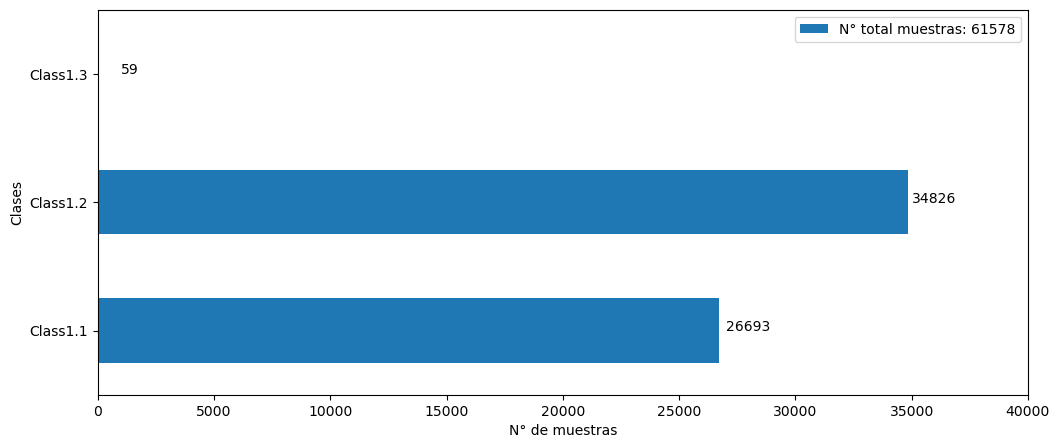

In [ ]:
plt.figure(figsize=(12,5))
df_class.reset_index()[['Class1.1', 'Class1.2', 'Class1.3']].sum().plot(kind='barh')
plt.annotate('26693',(27000,0))
plt.annotate('34826',(35000,1))
plt.annotate('59',(1000,2))
plt.legend(['N° total muestras: 61578'])
plt.ylabel('Clases')
plt.xlabel('N° de muestras')
plt.xlim([0,40000])

## Gráficos para muestras aleatorias y comportamiento de clases

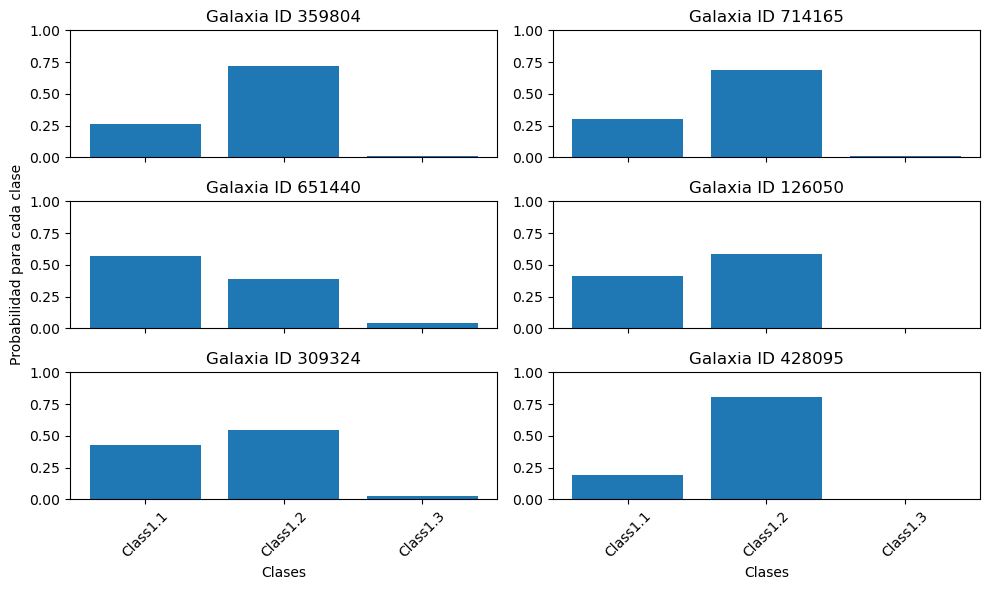

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(10, 6), sharex=True)

x = np.arange(1,len(df_train_sol)) # indices posibles

for i in range(6):
    idx = random.choice(x) # Aleatoriza la muestra para mejor analisis
    etiquetas = df_train_sol.columns[1:]
    alturas = df_train_sol.iloc[idx, 1:].tolist()

    row, col = divmod(i, 2)
    ax = axes[row, col]

    ax.bar(etiquetas, alturas)
    if i==2:
         ax.set_ylabel('Probabilidad para cada clase')
    if i>=4:
        ax.set_xlabel('Clases')
        ax.tick_params(axis='x', rotation=45)

    ax.set_title('Galaxia ID {}'.format(df_train_sol['GalaxyID'][idx]))
    ax.set_ylim([0,1])

plt.tight_layout()
plt.show()

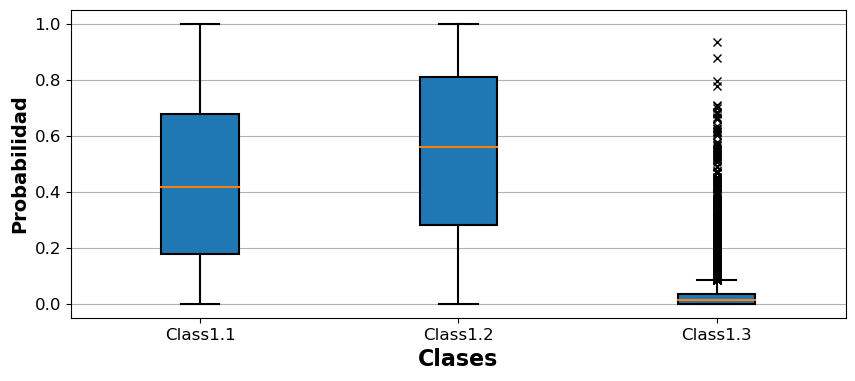

In [ ]:
# Se muestra la probabilidad por clase de todas las muestras en forma de boxplot
fig, ax = plt.subplots(1,1,figsize=(10, 4))
df = df_train_sol[df_train_sol.columns[1:]]

box = df.plot(kind='box', ax=ax, fontsize=12, patch_artist=True,
             color=dict(boxes='r', whiskers='r', medians='r', caps='r'),
             boxprops=dict(linestyle='-', linewidth=1.5),
             flierprops=dict(marker='x'),
             medianprops=dict(linestyle='-', linewidth=1.5),
             whiskerprops=dict(linestyle='-', linewidth=1.5),
             capprops=dict(linestyle='-', linewidth=1.5),
             showfliers=True, rot=0)

ax.yaxis.grid(True)
ax.set_xlabel('Clases', fontsize=16, fontweight='bold')
ax.set_ylabel('Probabilidad', fontsize=14, fontweight='bold')
plt.show()

In [ ]:
path_train = 'images_training_rev1/'
path_test = 'images_test_rev1/'

In [ ]:
def plot_random_galaxy(path, sample = 4):
    random_image=random.sample(os.listdir(path),sample)

    plt.figure(figsize=(16,5))
    for i in range(sample):

        plt.subplot(1,sample,i+1)
        img=tf.io.read_file(os.path.join(path,random_image[i]))
        img=tf.io.decode_image(img)
        plt.imshow(img)
        plt.title(f'GalaxyID: {random_image[i][:-4]}', fontsize=14, fontweight='bold')
        plt.axis(False)

Se grafican muestras aleatorias para mostrar el tipo de datos que se manejará (imágenes)

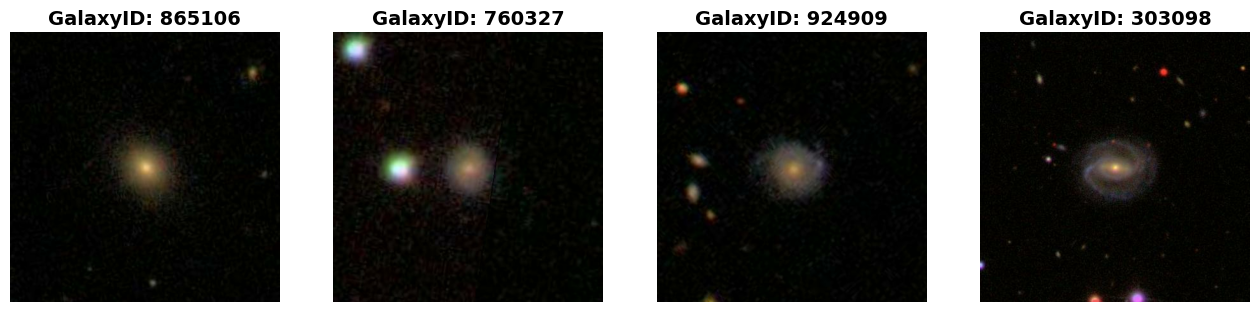

In [ ]:
plot_random_galaxy(path_train)

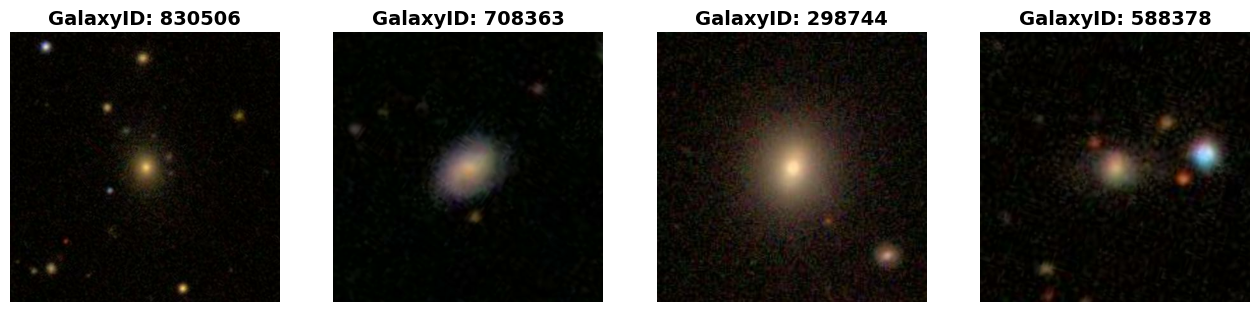

In [ ]:
plot_random_galaxy(path_test)

# Preparaciones

In [ ]:
# Lista de archivos de entrenamiento
files = os.listdir(path_train)
files.sort()

In [ ]:
# Checking info of image, minmax and resolution
image = Image.open(path_train + files[1])

print("Infor. Imagen")
print(image.format)
print(image.size)
print(image.mode)

Infor. Imagen
JPEG
(424, 424)
RGB


In [ ]:
# Usar GPU si esta disponible
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Processor available:",device)

Processor available: cpu


In [ ]:
# Transformaciones y augmentation
transform_image = transforms.Compose([transforms.ToTensor(),
                                      transforms.RandomRotation(360), # Not sure about this one
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),
                                      transforms.CenterCrop(224),
                                      transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

transform_valtest = transforms.Compose([transforms.ToTensor(),
                                       transforms.CenterCrop(224),
                                       transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

In [ ]:
# Modelo
model = torch.hub.load("facebookresearch/dinov2", "dinov2_vits14_reg") # 384 emb
#model = torch.hub.load("facebookresearch/dinov2", "dinov2_vitb14") # 768 emb
#model = torch.hub.load("facebookresearch/dinov2", "dinov2_vitl14") # 1024 emb
#model = torch.hub.load("facebookresearch/dinov2", "dinov2_vitg14") # 1536 emb

Using cache found in /Users/yisus/.cache/torch/hub/facebookresearch_dinov2_main
/Users/yisus/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/Users/yisus/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/Users/yisus/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vits14/dinov2_vits14_reg4_pretrain.pth" to /Users/yisus/.cache/torch/hub/checkpoints/dinov2_vits14_reg4_pretrain.pth
100%|██████████| 84.2M/84.2M [00:05<00:00, 15.7MB/s]


## Etiquetas (binario)

In [ ]:
df_class.head()

,Class1.1,Class1.2,Class1.3
GalaxyID,,,
100008,0.0,1.0,0.0
100023,0.0,1.0,0.0
100053,1.0,0.0,0.0
100078,1.0,0.0,0.0
100090,1.0,0.0,0.0


In [ ]:
# Si es necesario quitar la 3ra clase:
y = df_class[df_class['Class1.3']!=1.0]
y = y.drop(columns='Class1.3')
#y2['target'] = y2.target - 1
y.head()

# Con esto queda un problema binario de clasificacion con 0 = eliptico, 1 = espiral

,Class1.1,Class1.2
GalaxyID,,
100008,0.0,1.0
100023,0.0,1.0
100053,1.0,0.0
100078,1.0,0.0
100090,1.0,0.0


## GalaxyID a imagen

In [ ]:
# Función para obtener imagen y etiqueta según GalaxyID
def ID2img(ID):
    #label = y.loc[ID].values

    img = path_train + str(ID)+'.jpg'
    img = Image.open(img)
    return img #label

### Ejemplo 1 imagen

In [ ]:
# Obtiene imagen y etiqueda para la primera GalaxyID
img = ID2img(y.index.values[1])

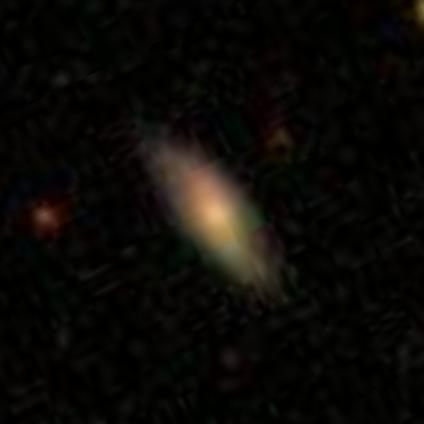

In [ ]:
# Imagen
img

In [ ]:
# Transformaciones
img = transform_image(img).unsqueeze(0)
print(img.size())

torch.Size([1, 3, 224, 224])


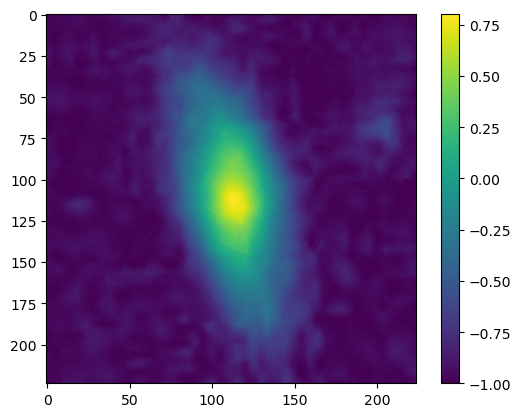

In [ ]:
plt.imshow(img[0,0,:,:])
plt.colorbar()

In [ ]:
# Obtener embedding (este proceso será interno en la arquitectura)
emb = model(img)

In [ ]:
emb

tensor([[-2.1520e+00, -1.3840e+00, -1.5765e+00, -7.3264e-02,  1.3460e+00,
          8.9737e-01,  5.9748e-02, -4.9017e-01,  1.1037e-01, -3.4239e-03,
         -8.8621e-01,  1.7252e-01,  1.1730e+00, -7.0557e-01,  4.1608e-01,
         -1.3155e+00, -6.9815e-01,  2.0569e-01, -7.6260e-01,  9.6218e-01,
          9.3104e-01, -2.2160e-01,  7.0167e-01, -3.1989e-02,  2.7739e+00,
         -1.0168e+00, -7.3088e-01, -1.8424e+00,  1.3399e-01,  3.2157e+00,
         -1.1355e+00, -2.8504e-01, -7.9388e-01,  1.2612e+00,  1.4238e-01,
         -1.7686e+00,  3.1441e-01,  8.1037e-01, -8.0176e-01,  2.3398e+00,
         -1.1698e+00,  1.0193e+00,  1.1966e+00,  1.2024e+00, -1.0276e+00,
         -3.3795e-02, -1.3993e+00, -7.0856e-01, -1.2467e+00, -8.2763e-01,
         -1.7427e-01,  3.4706e-01, -5.0566e-01,  4.2294e-01,  4.3072e-01,
          5.3809e-02,  1.1249e+00,  3.4167e-01, -1.4327e+00,  1.7306e+00,
         -1.8672e+00,  5.3668e-01, -8.2756e-01, -1.0478e+00,  2.2963e+00,
         -1.8165e+00,  1.1405e+00,  1.

In [ ]:
model_output = emb.squeeze().size(0)
print("Model output size:",model_output)

Model output size: 384


In [ ]:
# Datos a utilizar para entrenamiento, considerar que se usará ID2img y transforms especificados más arriba
X = y.index.values
y = y.to_numpy()

In [ ]:
X

array([100008, 100023, 100053, ..., 999958, 999964, 999967])

In [ ]:
y

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [1., 0.]])

# Dataset y Dataloader

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25)

In [ ]:
print("Size train:", X_train.shape)
print("Size val:", X_val.shape)
print("Size test:", X_test.shape)

Size train: (30912,)
Size val: (10305,)
Size test: (20302,)


In [ ]:
y_train = torch.tensor(y_train, dtype=torch.long)
y_val = torch.tensor(y_val, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

In [ ]:
class CDataset(torch.utils.data.Dataset):
    # CustomDataset modificado de código de prácticas.
    def __init__(self, galaxyid, labels, tfr, tfr_model):
        self.data = galaxyid # X
        self.labels = labels # y
        self.transform = tfr
        self.transform_model = tfr_model

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        ID = self.data[idx]
        img = ID2img(ID) # unsqueeze(0)

        if self.transform:
            img = self.transform(img)
            img = self.transform_model(img.unsqueeze(0)).squeeze(0)

        return img, self.labels[idx]

In [ ]:
class CDataloader(torch.utils.data.DataLoader):
    def __init__(self, Xtrain, ytrain, Xval, yval, Xtest, ytest,
                    tfr_train  = None,
                    tfr_val    = None,
                    tfr_test   = None,
                    tfr_model  = None,
                    batch_size = 64,
                    shuffle    = False):

        # Atributes and labels
        self.xtrain, self.ytrain = Xtrain, ytrain
        self.xval, self.yval     = Xval, yval
        self.xtest, self.ytest   = Xtest, ytest

        # Number of categories
        self.nb_labels = self.ytrain.size(1)

        # Transformations
        self.tfr_train = tfr_train
        self.tfr_val   = tfr_val
        self.tfr_test  = tfr_test

        self.tfr_model = tfr_model

        # Loader
        self.__loader(batch_size, shuffle)

    def __loader(self, batch_size, shuffle):

        # Create the Datasets
        train_set = CDataset(galaxyid = self.xtrain, labels = self.ytrain, tfr=self.tfr_train, tfr_model = self.tfr_model)
        val_set   = CDataset(galaxyid = self.xval  , labels = self.yval  , tfr=self.tfr_val,   tfr_model = self.tfr_model)
        test_set  = CDataset(galaxyid = self.xtest , labels = self.ytest , tfr=self.tfr_test,  tfr_model = self.tfr_model)

        # Create the Dataloaders
        self.train_set = torch.utils.data.DataLoader(dataset   = train_set,
                                                    batch_size = batch_size,
                                                    shuffle    = shuffle)

        self.val_set   = torch.utils.data.DataLoader(dataset   = val_set,
                                                    batch_size = batch_size,
                                                    shuffle    = False)

        self.test_set  = torch.utils.data.DataLoader(dataset   = test_set,
                                                    batch_size = batch_size,
                                                    shuffle    = False)

In [ ]:
# Ejecucion datos
loader = CDataloader(Xtrain = X_train, ytrain = y_train, Xval = X_val, yval = y_val, Xtest = X_test, ytest = y_test,
                                tfr_train  = transform_image,
                                tfr_val    = transform_valtest,
                                tfr_test   = transform_valtest,
                                tfr_model  = model,
                                batch_size = 64,
                                shuffle    = True)

print(f"CDataloader fue ejecutado correctamente")
print(110*"_")

# Checking input size and number of classes ---------------------------------------------------------#
input_size  = loader.train_set.dataset.data.shape
num_classes = loader.nb_labels

print(f"Input del dataset:        {input_size}")
print(f"Cantidad de categorias:   {num_classes}")

CDataloader fue ejecutado correctamente
______________________________________________________________________________________________________________
Input del dataset:        (30912,)
Cantidad de categorias:   2


In [ ]:
# Testing functionality of loader
#train_features, train_labels = next(iter(loader.train_set))

#print("Loader train_data batch size :", train_features.size())
#print("Loader train_label batch size:", train_labels.size())

In [ ]:
# Revisemos embeddings desde Dataloader
#img = train_features[0].squeeze()
#label = train_labels[0]
#plt.imshow(img[0,:,:])
#plt.colorbar()
#plt.show()
#print(f"Label: {label}")

# Trainer

In [ ]:
class EarlyStopping:
    # EarlyStopping basado en la métrica (Accuracy)
    def __init__(self, patience=5, delta=0.001, verbose=False):
        # Inicializar parámetros
        self.best_metric = -np.Inf
        self.counter = 0
        self.patience = patience
        self.delta = delta
        self.verbose = verbose

    # Contador para EarlyStopping
    def count(self, metric):
        # Si métrica es mejor que la anterior + delta, is_best = True
        is_best = bool(metric > (self.best_metric+self.delta))

        # Actualizamos el valor del contador
        if is_best: # Si is_best = True, reiniciar contador
            print(f'Incremento en Accuracy: [{self.best_metric:.6f} > {metric:.6f}]. Creando checkpoint.')
            self.counter = 0
        else: # Caso contrario, incrementar contador para EarlyStopping
            print(f'Sin mejora en Accuracy: [{self.counter}/{self.patience}]')
            self.counter += 1

        # Actualizamos métrica si es mayor a la ya definida
        self.best_metric = max(metric, self.best_metric)

        # Analizamos si es necesario o no detener el entrenamiento
        stop = bool(self.counter > self.patience)

        return stop, is_best

In [ ]:
class CTrainer(object):
    def __init__(self, arch, hyper, model_instance, verbose=True):
        super(CTrainer, self).__init__()
        self.architecture   = arch                                                # Parametros de la red
        self.hyperparams    = hyper                                               # Hiperparametros del modelo
        self.model_class    = model_instance                                      # Modelo que usaremos
        self.verbose        = verbose                                             # Si desamos o no los prints

    def compile(self, load_checkpoint,ckpt="trained_parameters.pth"):
        self.model      = self.model_class(self.architecture).to(device)
        self.loss       = torch.nn.CrossEntropyLoss() # Por el momento que es binario
        self.optimizer  = torch.optim.Adam(params=self.model.parameters(), lr = self.hyperparams["lr"])
        self.early_stop = EarlyStopping(patience=self.hyperparams["patience"], delta=0.001)

        self.history   = {  "epochs"    : [],
                            "train_loss": [], "train_metric":[],
                            "val_loss"  : [], "val_metric"  :[]}

        if load_checkpoint:
            state_dict = torch.load('{}/{}'.format(self.hyperparams["exp"],ckpt))

            self.model.load_state_dict(state_dict['model'])
            self.optimizer.load_state_dict(state_dict['optim'])

            print('Training parameters restored.')

    def fit(self, train_dl, val_dl):
        for epoch in range(0, self.hyperparams["nepochs"]+1):
            train_loss, train_metric = self.__train_one_epoch(train_dl)
            val_loss  , val_metric   = self.__val_one_epoch(val_dl)

            epoch_train_loss     = np.mean(train_loss)
            epoch_train_metric   = np.mean(train_metric)

            epoch_val_loss       = np.mean(val_loss)
            epoch_val_metric     = np.mean(val_metric)

            if self.verbose:
                print(f'\nEpoch: {epoch}/{self.hyperparams["nepochs"]} '
                        + f'loss = {epoch_train_loss:.4f}, '
                        + f'metric = {epoch_train_metric:.4f}, ')

            self.history["epochs"].append(epoch)
            self.history["train_loss"].append(epoch_train_loss)
            self.history["train_metric"].append(epoch_train_metric)
            self.history["val_loss"].append(epoch_val_loss)
            self.history["val_metric"].append(epoch_val_metric)

            stop, is_best = self.early_stop.count(epoch_val_metric)

            if is_best:
                cpkt = {'model': self.model.state_dict(),
                        'optim': self.optimizer.state_dict()}
                torch.save(cpkt, './{}/trained_parameters.pth'.format(self.hyperparams["exp"]))
                print("")
            if stop:
                break

    def summary(self):
        print(110*"_")
        print(self.model)
        for layer, param in self.model.named_parameters():
            print(100*"-")
            print(f'layer.param_type:    {layer}')
            print(f"n-params        :    {param.numel()}")
            print(100*"-")
        print(110*"_")

    def __train_one_epoch(self, dataloader):
        self.model.train()

        train_loss   = []
        train_metric = []

        for X_train, y_train in tqdm(dataloader, miniters=1):

            X_train = X_train.to(device)
            y_train = y_train.to(device)

            y_pred       = self.model(X_train.float())

            score_loss   = self.loss(y_pred, y_train.float())

            y            = torch.argmax(y_train, dim=-1).detach().numpy()
            y_hat        = torch.argmax(y_pred , dim=-1).detach().numpy()
            score_metric = accuracy_score(y, y_hat)

            # back, step, zero
            score_loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad(set_to_none=True)

            train_loss.append(score_loss.item())
            train_metric.append(score_metric)
        return train_loss, train_metric

    def __val_one_epoch(self, dataloader):
        self.model.eval()

        val_loss   = []
        val_metric = []

        with torch.no_grad():
            for X_val, y_val in tqdm(dataloader, miniters=1):
                y_preds_val  = self.model(X_val.float())

                score_loss   = self.loss(y_preds_val, y_val.float())

                y            = torch.argmax(y_val, dim=-1).detach().numpy()
                y_hat        = torch.argmax(y_preds_val , dim=-1).detach().numpy()
                score_metric = accuracy_score(y, y_hat)

                val_loss.append(score_loss.item())
                val_metric.append(score_metric)
        return val_loss, val_metric

    def evaluate(self, dataloader):
        self.model.eval()

        loss_list   = []
        metric_list = []

        with torch.no_grad():
            for X_test, y_test in tqdm(dataloader, miniters=1):
                y_preds_test = self.model(X_test.float())

                score_loss   = self.loss(y_preds_test, y_test.float())

                y            = torch.argmax(y_test, dim=-1).detach().numpy()
                y_hat        = torch.argmax(y_preds_test , dim=-1).detach().numpy()
                score_metric = accuracy_score(y, y_hat)

                loss_list.append(score_loss.item())
                metric_list.append(score_metric)

                loss_out = np.mean(loss_list)
                metric   = np.mean(metric_list)
        return loss_out, metric

    def predict(self, X):
        self.model.eval()

        y_pred_prob = []
        y_pred      = []

        with torch.no_grad():
            X      = X.float()
            out    = self.model(X)

            y_hat_prob = torch.nn.functional.softmax(out, dim=1)
            y_hat      = torch.argmax(y_hat_prob, axis=1)
        return y_hat_prob, y_hat

# Arquitectura

In [ ]:
class DinoV2Classifier(nn.Module):
    def __init__(self, Args_dict):
        super(DinoV2Classifier, self).__init__()
        emb_size = Args_dict["emb_size"]
        out_size = Args_dict["out_size"]

        self.act1 = nn.ReLU()
        self.act2 = nn.Sigmoid()

        self.fc1 = nn.Linear(emb_size, 256)
        self.fc2 = nn.Linear(256, out_size)

    def forward(self, x):
        x = self.act1(self.fc1(x))
        x = self.act2(self.fc2(x))
        return x

# Compilación

In [ ]:
architecture = {"emb_size": model_output, "out_size": num_classes}
hyperparams  = {"nepochs": 30, "lr":0.0001, "patience": 5, "exp": "./Model"}

In [ ]:
DINO = CTrainer(arch = architecture, hyper = hyperparams, model_instance = DinoV2Classifier)
DINO.compile(load_checkpoint=False,ckpt="trained_parameters_batch64.pth")
DINO.summary()

______________________________________________________________________________________________________________
DinoV2Classifier(
  (act1): ReLU()
  (act2): Sigmoid()
  (fc1): Linear(in_features=384, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=2, bias=True)
)
----------------------------------------------------------------------------------------------------
layer.param_type:    fc1.weight
n-params        :    98304
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
layer.param_type:    fc1.bias
n-params        :    256
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
layer.param_type:    fc2.weight
n-params        :    512
----------------------------------

In [ ]:
for idx, m in enumerate(DINO.model.named_modules()):
    print(idx, '->', m)

0 -> ('', DinoV2Classifier(
  (act1): ReLU()
  (act2): Sigmoid()
  (fc1): Linear(in_features=384, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=2, bias=True)
))
1 -> ('act1', ReLU())
2 -> ('act2', Sigmoid())
3 -> ('fc1', Linear(in_features=384, out_features=256, bias=True))
4 -> ('fc2', Linear(in_features=256, out_features=2, bias=True))


In [ ]:
print("Entrenamiento DINOv2 Classifier")
print(110*"-")

DINO.fit(train_dl = loader.train_set, val_dl = loader.val_set)

Entrenamiento DINOv2 Classifier
--------------------------------------------------------------------------------------------------------------


  0%|          | 0/483 [00:03<?, ?it/s]


RuntimeError: HIP error: invalid device function
HIP kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing AMD_SERIALIZE_KERNEL=3.
Compile with `TORCH_USE_HIP_DSA` to enable device-side assertions.


In [ ]:
trainMetric = np.array(DINO.history["train_metric"])
valMetric= np.array(DINO.history["val_metric"])
print(valMetric)

[0.79024768 0.81656347 0.82159443 0.8250774  0.81666022 0.82943111
 0.82198142 0.83059211 0.83330108 0.83262384 0.82865712 0.83359133
 0.82952786 0.83630031 0.82827012 0.83233359 0.83968653 0.82846362
 0.84036378 0.83910604 0.83697755 0.83929954 0.82691563]


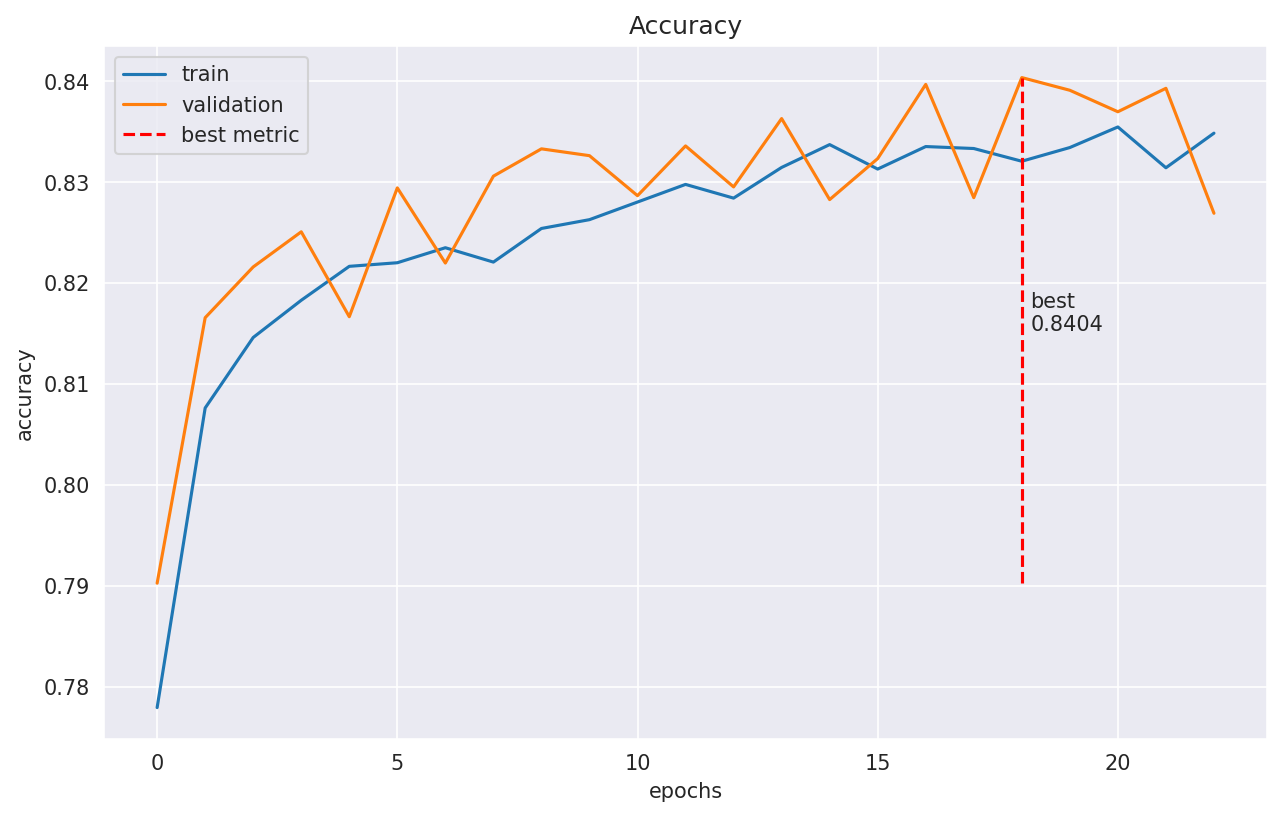

In [ ]:
plt.figure(figsize=(10,6),dpi=150)
plt.title("Accuracy")
sns.set_style("darkgrid")
plt.plot(trainMetric,label="train")
plt.plot(valMetric,label="validation")
plt.vlines(valMetric.argmax(),ymin=valMetric.min(),ymax=valMetric.max(),linestyles="--",colors="red",label="best metric")
plt.text(valMetric.argmax()*1.01, 1/2*(valMetric.max()+valMetric.min()),"best\n{}".format(np.round(valMetric.max(),4)))
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.legend()

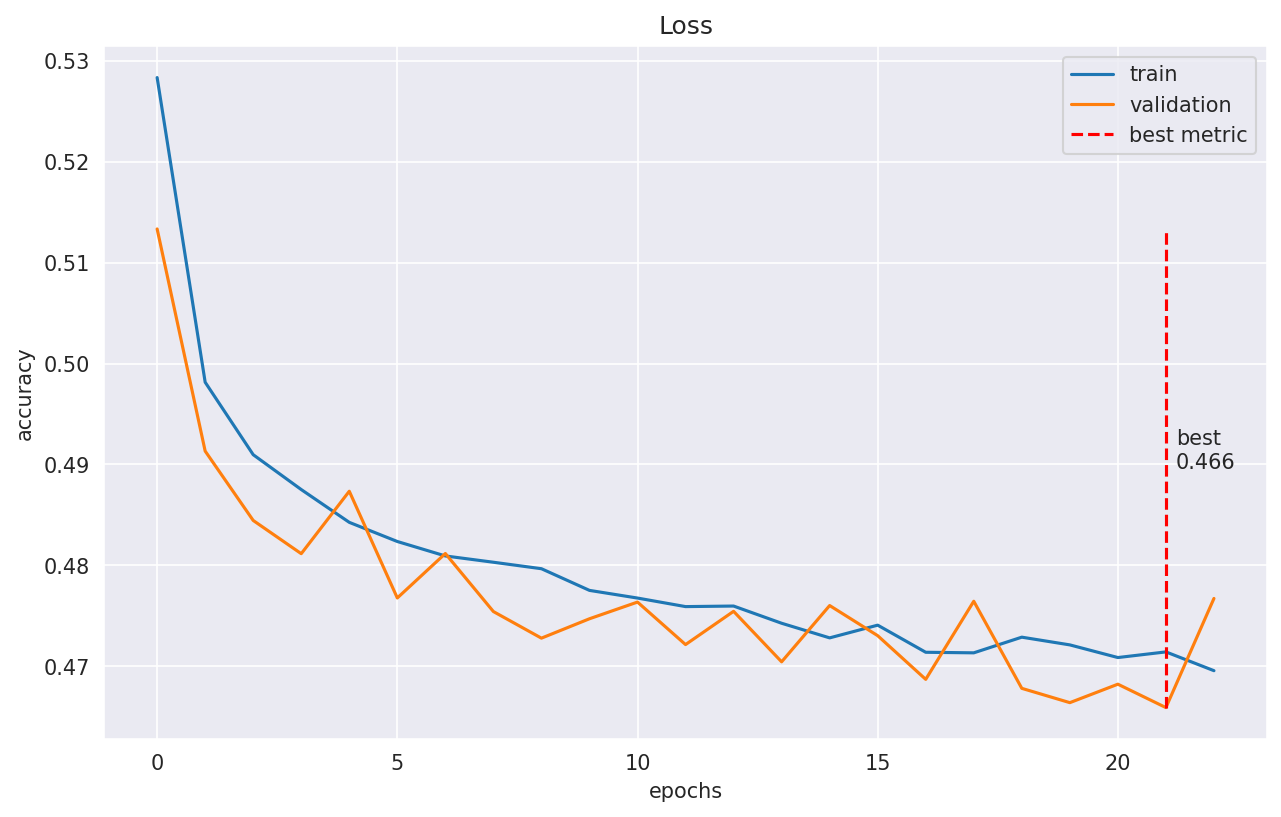

In [ ]:
trainLoss = np.array(DINO.history["train_loss"])
valLoss = np.array(DINO.history["val_loss"])

plt.figure(figsize=(10,6),dpi=150)
plt.title("Loss")
sns.set_style("darkgrid")
plt.plot(trainLoss,label="train")
plt.plot(valLoss,label="validation")
plt.vlines(valLoss.argmin(),ymin=valLoss.min(),ymax=valLoss.max(),linestyles="--",colors="red",label="best metric")
plt.text(valLoss.argmin()*1.01, 1/2*(valLoss.max()+valLoss.min()),"best\n{}".format(np.round(valLoss.min(),3)))
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.legend()

In [ ]:
DINO.evaluate(loader)

AttributeError: 'CDataloader' object has no attribute 'persistent_workers'